# Deep Kernel Learning with Flux

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/master/examples/2-deep-kernel-learning/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/2-deep-kernel-learning/).*

## Package loading
We use a couple of useful packages to plot and optimize
the different hyper-parameters

In [1]:
using KernelFunctions
using Flux
using Distributions, LinearAlgebra
using Plots
using ProgressMeter
using AbstractGPs
default(; legendfontsize=15.0, linewidth=3.0);

## Data creation
We create a simple 1D Problem with very different variations

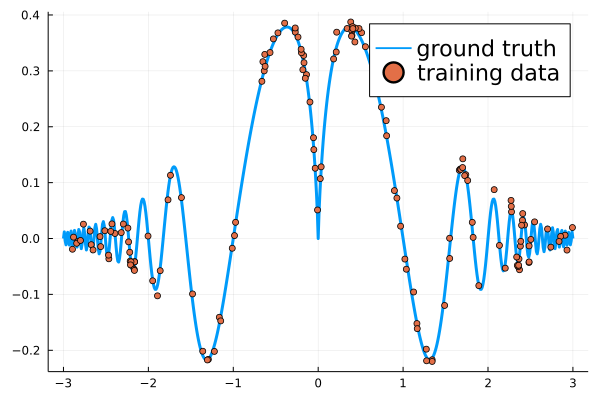

In [2]:
xmin, xmax = (-3, 3)  # Limits
N = 150
noise_std = 0.01
x_train = collect(eachrow(rand(Uniform(xmin, xmax), N))) # Training dataset
target_f(x) = sinc(abs(x)^abs(x)) # We use sinc with a highly varying value
target_f(x::AbstractArray) = target_f(only(x))
y_train = target_f.(x_train) + randn(N) * noise_std
x_test = collect(eachrow(range(xmin, xmax; length=200))) # Testing dataset

plot(xmin:0.01:xmax, target_f; label="ground truth")
scatter!(map(only, x_train), y_train; label="training data")

## Model definition
We create a neural net with 2 layers and 10 units each.
The data is passed through the NN before being used in the kernel.

In [3]:
neuralnet = Chain(Dense(1, 20), Dense(20, 30), Dense(30, 5))

Chain(
  Dense(1, 20),                         # 40 parameters
  Dense(20, 30),                        # 630 parameters
  Dense(30, 5),                         # 155 parameters
)                   # Total: 6 arrays, 825 parameters, 3.598 KiB.

We use the Squared Exponential Kernel:

In [4]:
k = SqExponentialKernel() ∘ FunctionTransform(neuralnet)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: Chain(Dense(1, 20), Dense(20, 30), Dense(30, 5))

We now define our model:

In [5]:
gpprior = GP(k)  # GP Prior
fx = AbstractGPs.FiniteGP(gpprior, x_train, noise_std^2)  # Prior at the observations
fp = posterior(fx, y_train)  # Posterior of f given the observations

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.FunctionTransform{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.FunctionTransform{Flux.Chain{Tuple{Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Flux.Dense{typeof(identity), Matrix{Float32}, Vector{F

This computes the log evidence of `y`, which is going to be used as the objective:

In [6]:
loss(y) = -logpdf(fx, y)

@info "Initial loss = $(loss(y_train))"

[ Info: Initial loss = 6139.50448925664


Flux will automatically extract all the parameters of the kernel

In [7]:
ps = Flux.params(k)

Params([Float32[-0.26516032; 0.20504129; … ; 0.24450675; -0.3587083;;], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.2783802 -0.3226616 … 0.2442297 0.3324325; -0.03616573 -0.07610614 … 0.3103493 -0.029803526; … ; 0.32863128 0.1691657 … 0.04888956 -0.29346263; 0.1456583 0.11346311 … 0.119066596 -0.25812954], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.020243764 0.40137762 … 0.28387478 0.25067416; -0.21003388 0.05326461 … 0.33874148 -0.4008405; … ; 0.06129352 -0.021074101 … -0.053785972 0.05263022; 0.042702537 -0.070115946 … 0.23692045 0.010571058], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

We show the initial prediction with the untrained model

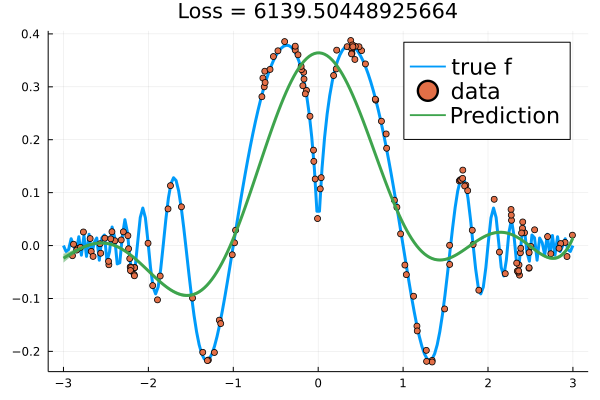

In [8]:
p_init = Plots.plot(
    vcat(x_test...), target_f; lab="true f", title="Loss = $(loss(y_train))"
)
Plots.scatter!(vcat(x_train...), y_train; label="data")
pred = marginals(fp(x_test))
Plots.plot!(vcat(x_test...), mean.(pred); ribbon=std.(pred), label="Prediction")

## Training

┌ Warning: Assignment to `pred` in soft scope is ambiguous because a global variable by the same name exists: `pred` will be treated as a new local. Disambiguate by using `local pred` to suppress this warning or `global pred` to assign to the existing global variable.
└ @ string:16
Progress:  10%|████                                     |  ETA: 0:01:17[ Info: 100/1000; loss = -191.8409193087581
Progress:  20%|████████▏                                |  ETA: 0:01:05[ Info: 200/1000; loss = -191.56752054303382
Progress:  30%|████████████▎                            |  ETA: 0:00:57[ Info: 300/1000; loss = -191.66598921836805
Progress:  40%|████████████████▍                        |  ETA: 0:00:48[ Info: 400/1000; loss = -191.81913246166627
Progress:  50%|████████████████████▍                    |  ETA: 0:00:39[ Info: 500/1000; loss = -191.877091651817
Progress:  60%|████████████████████████▌                |  ETA: 0:00:30[ Info: 600/1000; loss = -191.83389906996885
Progress:  70%|█████████

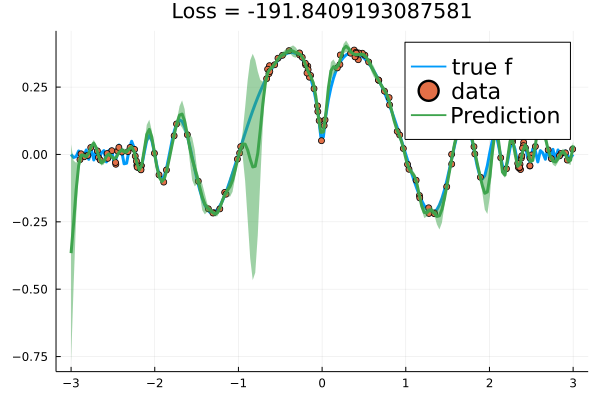

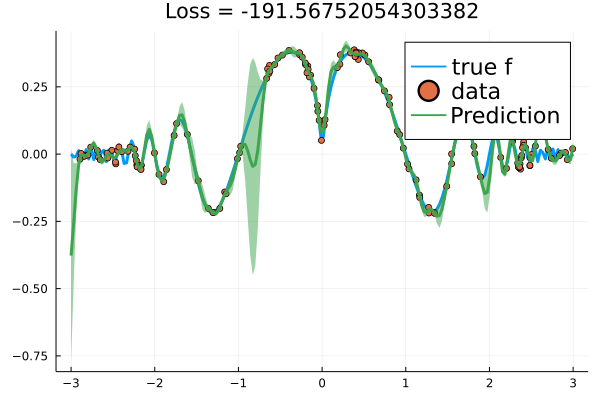

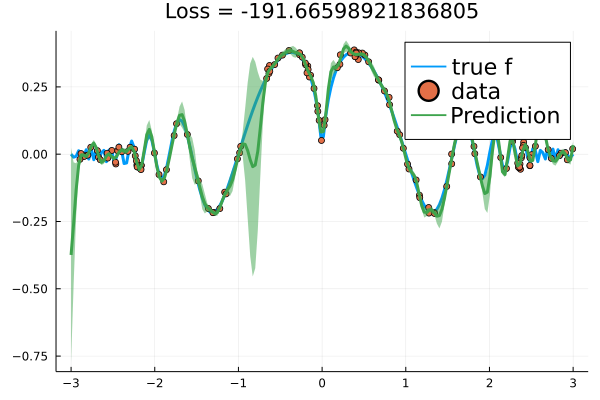

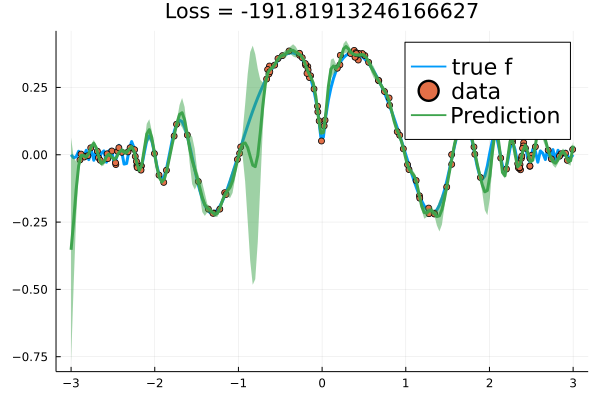

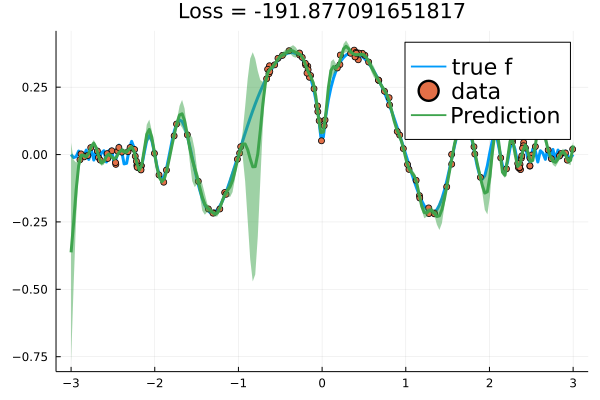

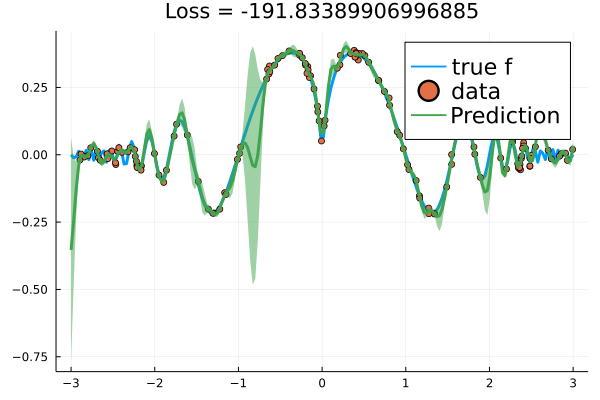

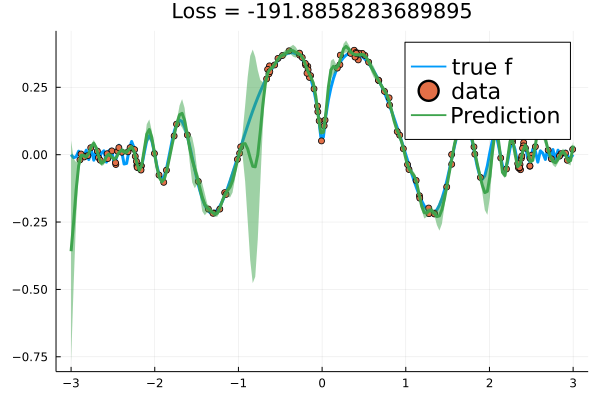

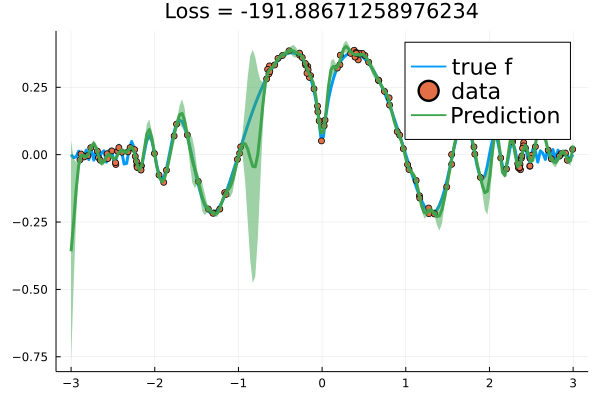

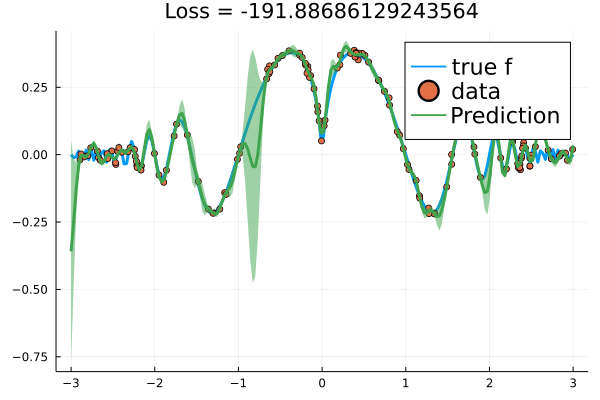

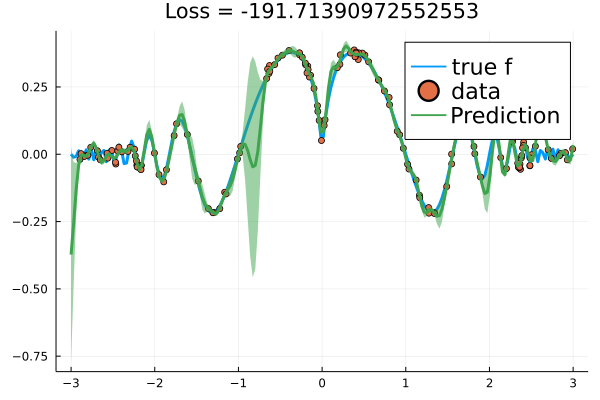

Plots.AnimatedGif("/tmp/jl_48i4GW.gif")
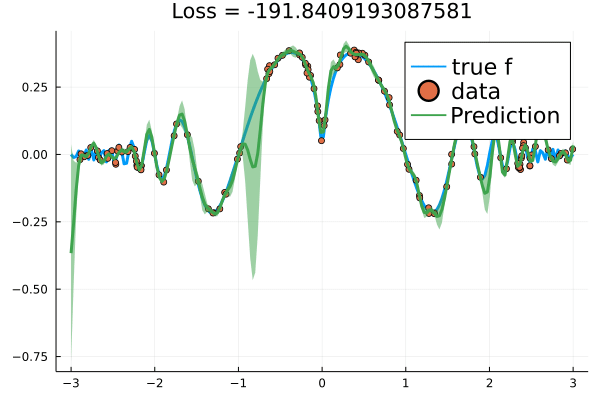

In [9]:
anim = Animation()
nmax = 1000
opt = Flux.ADAM(0.1)
@showprogress for i in 1:nmax
    global grads = gradient(ps) do
        loss(y_train)
    end
    Flux.Optimise.update!(opt, ps, grads)
    if i % 100 == 0
        L = loss(y_train)
        @info "$i/$nmax; loss = $L"
        p = Plots.plot(
            vcat(x_test...), target_f; lab="true f", title="Loss = $(loss(y_train))"
        )
        p = Plots.scatter!(vcat(x_train...), y_train; lab="data")
        pred = marginals(posterior(fx, y_train)(x_test))
        Plots.plot!(vcat(x_test...), mean.(pred); ribbon=std.(pred), lab="Prediction")
        frame(anim)
        display(p)
    end
end
gif(anim; fps=5)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*